# 1D VP-System with FVM

## 输入库

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.interpolate import lagrange
from scipy.special import roots_sh_legendre

n = 5
theta = 0.0*2*np.pi

xMin = 0.44
xMax = 0.57
yMin = 1.35
yMax = 1.45

## 功能函数

2D 拉格朗日插值

In [237]:
def TestF(x,y,xDiv,yDiv):

  x1 = np.cos(theta)*x + np.sin(theta)*y
  y1 = -np.sin(theta)*x + np.cos(theta)*y
  x1x = np.cos(theta)
  x1y = np.sin(theta)
  y1x = -np.sin(theta)
  y1y = np.cos(theta)

  k1 = 0.05*np.pi
  k2 = 0.1*np.pi
  phi1 = k1*(x1+7)
  phi2 = k2*(y1+4)

  f1 = np.cos(phi1)
  f2 = np.sin(phi2)

  f1x1 = -k1*np.sin(phi1)
  f2x1 = 0.0
  f1y1 = 0.0
  f2y1 =  k2*np.cos(phi2)

  if xDiv==1:
    f1x = f1x1*x1x+f1y1*y1x
    f2x = f2x1*x1x+f2y1*y1x
    re = f1*f2x + f1x*f2
  elif yDiv==1:
    f1y = f1x1*x1y+f1y1*y1y
    f2y = f2x1*x1y+f2y1*y1y
    re = f1*f2y + f1y*f2
  else:
    re = f1*f2
  
  return re

In [238]:
def LagF(xNode,yNode,xyRange,zNode,x,y,xDiv,yDiv):
  xMin,yMin,xLen,yLen = xyRange
  x0 = (x-xMin)/xLen
  y0 = (y-yMin)/yLen

  Nx,Ny = zNode.shape
  re = 0.0

  Lix = Li if xDiv==0 else divLi
  Liy = Li if yDiv==0 else divLi

  facX = 1/xLen if xDiv==1 else 1
  facY = 1/yLen if yDiv==1 else 1

  for i in range(0,Nx):
    for j in range(0,Ny):
      re += zNode[i,j]*Lix(xNode[:,0],i,x0)*Liy(yNode[0,:],j,y0)
  return re*facX*facY


def Li_unit(x0,x1,x):
  return (x-x1)/(x0-x1)


def Li(xNode,i,x):
  N = xNode.shape[0]
  re = 1.0
  for j in range(0,N):
    if j != i:
      re *= Li_unit(xNode[i],xNode[j],x)
  return re

def divLi(xNode,i,x):
  err = 1e-10
  N = xNode.shape[0]
  re = 0.0
  for j in range(0,N):
    if j != i:
      re += 1.0/((x-xNode[j]) + err)
  re *= Li(xNode,i,x)
  return re

In [239]:
def LBF(Node):
  N = Node.shape[0]
  LBFpoly = [np.poly1d([1]) for _ in range(N)]
  for i in range(N):
    for j in range(N):
      if i != j:
        LBFpoly[i] *= Li_unit_poly(Node[i],Node[j])
  return LBFpoly


def Li_unit_poly(x0,x1):
  return np.poly1d([1/(x0-x1),x1/(x1-x0)])


def LagF2(Xpolys,Ypolys,xyRange,zNode,x,y):
  xMin,yMin,xLen,yLen = xyRange
  x0 = (x-xMin)/xLen
  y0 = (y-yMin)/yLen
  xVals = np.array([poly(x0) for poly in Xpolys])
  yVals = np.array([poly(y0) for poly in Ypolys])
  re = 0.0
  for i in range(0,xVals.shape[0]):
    for j in range(0,yVals.shape[0]):
      re += xVals[i]*yVals[j]*zNode[i,j]
  return re


#def lagrange(xNode, yNode):
#    """Return the Lagrange polynomial for the given nodes."""
#    n = len(yNode)
#    if n == 1:
#        return lambda x: yNode[0]
#    else:
#        def lagrange(x):
#            result = 0
#            for j in range(n):
#                v = yNode[j]
#                for k in range(n):

In [240]:
nodes, weights = roots_sh_legendre(n)

In [241]:
xLen = xMax - xMin
yLen = yMax - yMin
xyRange = [xMin,yMin,xLen,yLen]

x = np.linspace(xMin,xMax,100).reshape(-1, 1)
y = np.linspace(yMin,yMax,100).reshape( 1,-1)

In [242]:
xL0 = nodes.reshape(-1, 1)
yL0 = nodes.reshape( 1,-1)

xL = xL0*xLen + xMin
yL = yL0*yLen + yMin
zL = TestF(xL,yL,0,0)

In [243]:
z0 = TestF(x,y,0,0)
zx0 = TestF(x,y,1,0)
zy0 = TestF(x,y,0,1)

In [244]:
z1 = LagF(xL0,yL0,xyRange,zL,x,y,0,0)
zx1 = LagF(xL0,yL0,xyRange,zL,x,y,1,0)
zy1 = LagF(xL0,yL0,xyRange,zL,x,y,0,1)


In [245]:
xL0Poly = LBF(nodes)
yL0Poly = LBF(nodes)
dxL0Poly = [poly.deriv() for poly in xL0Poly]
dyL0Poly = [poly.deriv() for poly in yL0Poly]
xIntL0Poly = [np.polyint(poly) for poly in xL0Poly]
yIntL0Poly = [np.polyint(poly) for poly in yL0Poly]

dxLPoly = [poly/xLen for poly in dxL0Poly]
dyLPoly = [poly/yLen for poly in dyL0Poly]
xIntLPoly = [poly*xLen for poly in xIntL0Poly]
yIntLPoly = [poly*yLen for poly in yIntL0Poly]

z2  = LagF2(xL0Poly,yL0Poly,xyRange,zL,x,y)
zx2 = LagF2(dxLPoly,yL0Poly,xyRange,zL,x,y)
zy2 = LagF2(xL0Poly,dyLPoly,xyRange,zL,x,y)

In [246]:
h = 1.0/(np.max(z0)-np.min(z0))
hx = 1.0/(np.max(zx0)-np.min(zx0))
hy = 1.0/(np.max(zy0)-np.min(zy0))

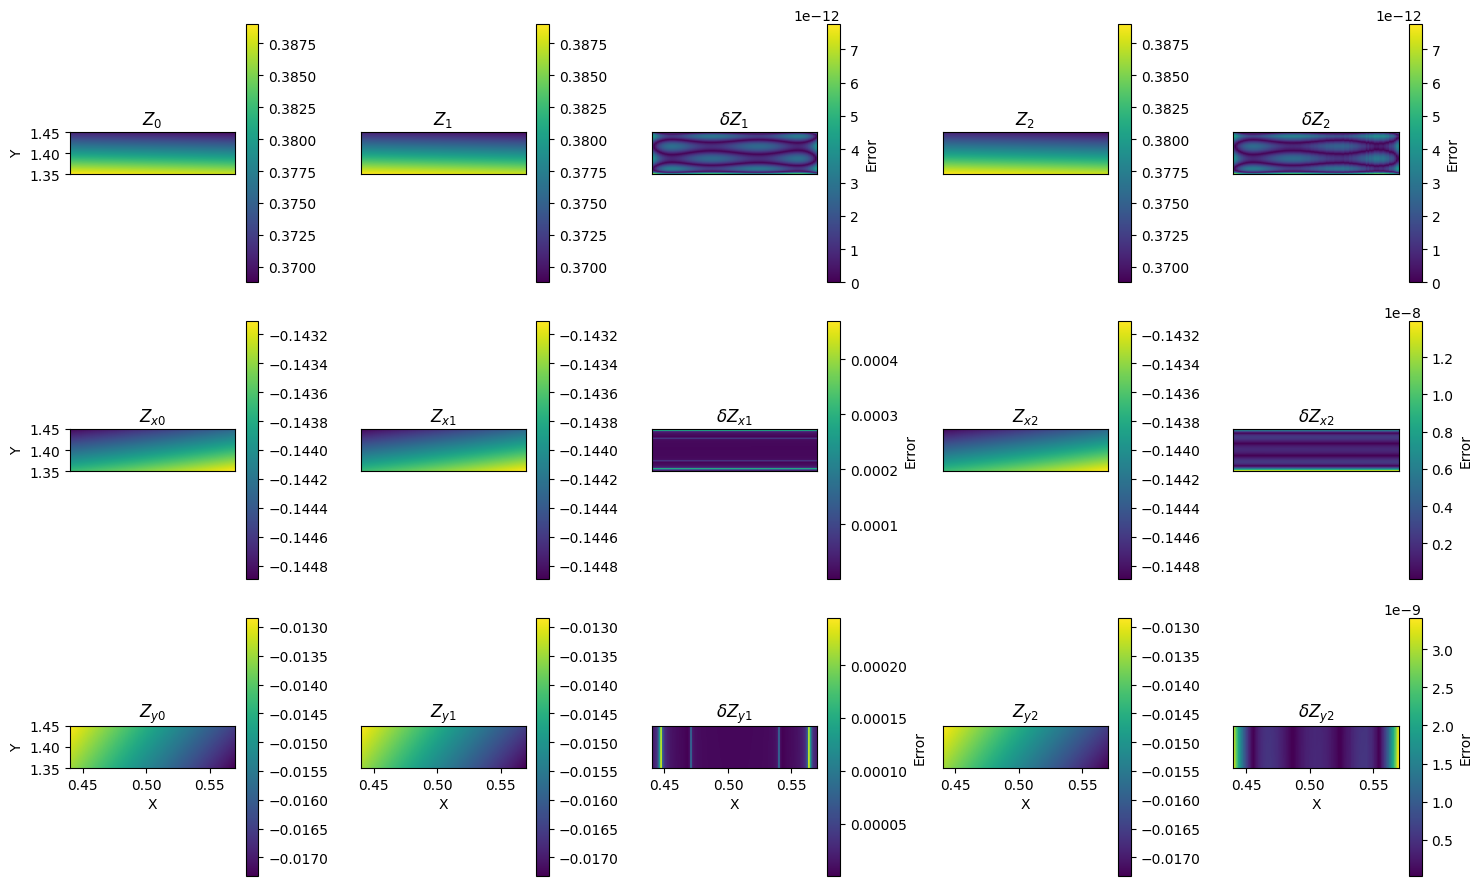

In [247]:
# Factor for adjusting the size of the figure
factor = 0.75

# Assuming you have defined x, y, z0, zx0, zy0, z1, zx1, zy1, z2, zx2, zy2, hy, hx, h, extent0 arrays/data

# Create figure and subplots
fig, axes = plt.subplots(3, 5, figsize=(20*factor, 12*factor))

# Define the extent
extent0 = [x.min(), x.max(), y.min(), y.max()]

# Plot data and colorbars
for i in range(3):
  for j in range(5):
    ax = axes[i, j]
    # Plot different images based on the subplot position
    if j == 0:
      if i == 0:
        im = ax.imshow(z0, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_0$'
      elif i == 1:
        im = ax.imshow(zx0, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{x0}$'
      else:
        im = ax.imshow(zy0, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{y0}$'
    elif j == 1:
      if i == 0:
        im = ax.imshow(z1, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_1$'
      elif i == 1:
        im = ax.imshow(zx1, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{x1}$'
      else:
        im = ax.imshow(zy1, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{y1}$'
    elif j == 2:
      if i == 0:
        im = ax.imshow(np.abs(z1 - z0) * h, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{1}$'
      elif i == 1:
        im = ax.imshow(np.abs(zx1 - zx0) * hx, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{x1}$'
      else:
        im = ax.imshow(np.abs(zy1 - zy0) * hy, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{y1}$'
    elif j == 3:
      if i == 0:
        im = ax.imshow(z2, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_2$'
      elif i == 1:
        im = ax.imshow(zx2, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{x2}$'
      else:
        im = ax.imshow(zy2, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{y2}$'
    elif j == 4:
      if i == 0:
        im = ax.imshow(np.abs(z2 - z0) * h, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{2}$'
      elif i == 1:
        im = ax.imshow(np.abs(zx2 - zx0) * hx, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{x2}$'
      else:
        im = ax.imshow(np.abs(zy2 - zy0) * hy, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{y2}$'
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    if j == 2 or j == 4:
      cbar.set_label('Error')

    # Set title
    ax.set_title(title)

    # Set labels
    if i == 2:
      ax.set_xlabel('X')
    else:
      ax.set_xticks([])
      ax.set_xticklabels([])

    if j == 0:
      ax.set_ylabel('Y')
    else:
      ax.set_yticks([])
      ax.set_yticklabels([])

# Adjust layout to prevent overlap
plt.tight_layout()
#plt.subplots_adjust(right=0.75)

# Set aspect ratio for each subplot (4:3)
for ax in axes.flatten():
    ax.set_aspect(1/3)

# Show the plot
plt.show()

积分

In [248]:
fx_NodeVal = np.array([poly(1)-poly(0) for poly in xL0Poly])
fy_NodeVal = np.array([poly(1)-poly(0) for poly in yL0Poly])
xInt_RangeVal = np.array([poly(1)-poly(0) for poly in xIntLPoly])
yInt_RangeVal = np.array([poly(1)-poly(0) for poly in yIntLPoly])

k1 = 0.05*np.pi
phi_xMin = k1*(xMin+7)
phi_xMax = k1*(xMax+7)
k2 = 0.1*np.pi
phi_yMin = k2*(yMin+4)
phi_yMax = k2*(yMax+4)

IntdxF0 = np.cos(phi_xMax) - np.cos(phi_xMin)
IntdyF0 = np.sin(phi_yMax) - np.sin(phi_yMin)
IntF0x = (np.sin(phi_xMax) - np.sin(phi_xMin))/k1
IntF0y = (np.cos(phi_yMin) - np.cos(phi_yMax))/k2

IntF = np.sum(xInt_RangeVal[:,None]*yInt_RangeVal[None,:]*zL)
IntdxF = np.sum(fx_NodeVal[:,None]*yInt_RangeVal[None,:]*zL)
IntdyF = np.sum(xInt_RangeVal[:,None]*fy_NodeVal[None,:]*zL)

IntF0 = IntF0x*IntF0y
IntdxF0 = IntdxF0*IntF0y
IntdyF0 = IntF0x*IntdyF0
#IntdxF0 = IntF0x*IntdyF0
#IntdyF0 = IntdxF0*IntF0y

print(IntF0,IntF,np.abs((IntF-IntF0)/IntF0))
print(IntdxF0,IntdxF,np.abs((IntdxF-IntdxF0)/IntdxF0))
print(IntdyF0,IntdyF,np.abs((IntdyF-IntdyF0)/IntdyF0))

0.0049260078854878086 0.004926007885487714 1.9192504689093432e-14
-0.0018722169973605146 -0.0018722169973398664 1.102874117862814e-11
-0.0001955011582753643 -0.00019550115826391656 5.855585958955901e-11


边界积分

In [249]:
k1 = 0.05*np.pi
phi_xMin = k1*(xMin+7)
phi_xMax = k1*(xMax+7)
k2 = 0.1*np.pi
phi_yMin = k2*(yMin+4)
phi_yMax = k2*(yMax+4)


F0xMin = np.cos(phi_xMin)
F0xMax = np.cos(phi_xMax)
F0yMin = np.sin(phi_yMin)
F0yMax = np.sin(phi_yMax)
IntF0x = (np.sin(phi_xMax) - np.sin(phi_xMin))/k1
IntF0y = (np.cos(phi_yMin) - np.cos(phi_yMax))/k2

IntxL0 = F0xMin*IntF0y
IntxR0 = F0xMax*IntF0y
IntyL0 = IntF0x*F0yMin
IntyR0 = IntF0x*F0yMax

#poly_y = np.poly1d([1,0])

xL_Val = np.array([poly(0) for poly in xL0Poly])
xR_Val = np.array([poly(1) for poly in xL0Poly])
yL_Val = np.array([poly(0) for poly in yL0Poly])
yR_Val = np.array([poly(1) for poly in yL0Poly])

IntxL = np.sum(xL_Val[:,None]*yInt_RangeVal[None,:]*zL)
IntxR = np.sum(xR_Val[:,None]*yInt_RangeVal[None,:]*zL)
IntyL = np.sum(xInt_RangeVal[:,None]*yL_Val[None,:]*zL)
IntyR = np.sum(xInt_RangeVal[:,None]*yR_Val[None,:]*zL)

print(IntxL0,IntxL,np.abs((IntxL-IntxL0)/IntxL0))
print(IntxR0,IntxR,np.abs((IntxR-IntxR0)/IntxR0))
print(IntyL0,IntyL,np.abs((IntyL-IntyL0)/IntyL0))
print(IntyR0,IntyR,np.abs((IntyR-IntyR0)/IntyR0))

0.038827160108730656 0.038827160108719304 2.923734415548876e-13
0.036954943111370146 0.03695494311137944 2.514191108164122e-13
0.04935377788827739 0.04935377788827097 1.300503656608366e-13
0.04915827673000203 0.049158276730007056 1.0219559188417925e-13


正交性

In [250]:
nl = len(xL0Poly)
Int = np.zeros((nl,nl))
Int0 = np.zeros((nl,nl))
Int1 = np.zeros((nl,nl))

for i in range (nl):
  coe = 1/(weights[i])
  for j in range (nl):
    ploy = np.polyint(np.polymul(xL0Poly[i],xL0Poly[j]))
    Int0[i,j] = (ploy(1) - ploy(0)) * coe
    Int0[i,j] = 0.0 if Int0[i,j]<0.0005 else Int0[i,j]

print(Int0)
print(np.trace(Int0))

for k in range (1):
  #ploy0 = xL0Poly[k]
  ploy0 = np.poly1d([1,0])
  for i in range (nl):
    coe = 1/(weights[i])
    for j in range (nl):
      ploy = np.polyint(np.polymul(np.polymul(xL0Poly[i],xL0Poly[j]),ploy0))
      Int0[i,j] = (ploy(1) - ploy(0)) * coe
      Int0[i,j] = 0.0 if Int0[i,j]<0.0005 else Int0[i,j]


  vL = 1.412
  vR = 1.93

  for k in range (1):
    #ploy0 = xL0Poly[k]
    ploy0 = np.poly1d([vR-vL,vL])
    nodes0 = nodes*(vR-vL)+vL
    for i in range (nl):
      coe = 1/(weights[i])
      for j in range (nl):
        ploy = np.polyint(np.polymul(np.polymul(xL0Poly[i],xL0Poly[j]),ploy0))
        Int1[i,j] = (ploy(1) - ploy(0)) * coe
        Int1[i,j] = 0.0 if Int1[i,j]<0.00005 else Int1[i,j]

  Int = nodes0*np.eye(n)

  print(Int0)
  print(np.trace(Int0))

  print(Int1)
  print(np.trace(Int1))

  print(Int)
  print(np.trace(Int))

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
5.000000000002546
[[0.04691008 0.         0.         0.         0.        ]
 [0.         0.23076534 0.         0.         0.        ]
 [0.         0.         0.5        0.         0.        ]
 [0.         0.         0.         0.76923466 0.        ]
 [0.         0.         0.         0.         0.95308992]]
2.500000000000592
[[1.43629942 0.         0.         0.         0.        ]
 [0.         1.53153645 0.         0.         0.        ]
 [0.         0.         1.671      0.         0.        ]
 [0.         0.         0.         1.81046355 0.        ]
 [0.         0.         0.         0.         1.90570058]]
8.354999999991703
[[1.43629942 0.         0.         0.         0.        ]
 [0.         1.53153645 0.         0.         0.        ]
 [0.         0.         1.671      0.         0.        ]
 [0.         0.         0.         1.81046355 0.        ]
 [0.         0.         0.         0.    

In [251]:
xL = 2.412
xR = 4.93
nodes0 = nodes*(xR-xL)+xL
#'''
y0 = np.exp(nodes0)
Int0 = (np.exp(xR)-np.exp(xL))
Int1 = (xR-1)*np.exp(xR) - (xL-1)*np.exp(xL)
'''
y0 = np.cos(nodes0)
Int0 = (np.sin(xR)-np.sin(xL))
Int1 = xR*np.sin(xR)+np.cos(xR) - xL*np.sin(xL)-np.cos(xL)
'''
Int0a = sum(y0*weights)*(xR-xL)
Int1a = sum(y0*nodes0*weights)*(xR-xL)

print(Int0,Int0a,(Int0a-Int0)/Int0)
print(Int1,Int1a,(Int1a-Int1)/Int1)

y0L0Poly = [np.poly1d([1]) for _ in range(n)]
yijPoly = [[np.poly1d([1]) for _ in range(n)] for _ in range(n)]
yij = np.zeros((n,n))


Mom0 = np.poly1d([0,1])
y0L0Poly = [np.polymul(x, Mom0) for x in xL0Poly[:n]]
for i in range(n):
  for j in range(n):
    yijPoly[i][j] = np.polyint(np.polymul(y0L0Poly[i],xL0Poly[j]))*y0[i]
    yij[i,j] = (yijPoly[i][j](1) - yijPoly[i][j](0))/weights[i]
    yij[i,j] = 0.0 if yij[i,j]<0.00005 else yij[i,j]

print(yij)
print(y0)

127.22326098983017 127.22326057663786 -3.247773303199742e-09
528.078856589661 528.0788509139204 -1.0747903455113605e-08
[[ 12.5550073    0.           0.           0.           0.        ]
 [  0.          19.94676827   0.           0.           0.        ]
 [  0.           0.          39.2911774    0.           0.        ]
 [  0.           0.           0.          77.39582677   0.        ]
 [  0.           0.           0.           0.         122.96262237]]
[ 12.5550073   19.94676827  39.2911774   77.39582677 122.96262237]


In [252]:
Mom0 = np.poly1d([xR-xL,xL])
y0L0Poly = [np.polymul(x, Mom0) for x in xL0Poly[:n]]
for i in range(n):
  for j in range(n):
    yijPoly[i][j] = np.polyint(np.polymul(y0L0Poly[i],xL0Poly[j]))*y0[i]
    yij[i,j] = (yijPoly[i][j](1) - yijPoly[i][j](0))/weights[i]
    yij[i,j] = 0.0 if yij[i,j]<0.00005 else yij[i,j]

yij = yij
print(yij)
print(y0*nodes0)

[[ 31.76566972   0.           0.           0.           0.        ]
 [  0.          59.70201662   0.           0.           0.        ]
 [  0.           0.         144.23791223   0.           0.        ]
 [  0.           0.           0.         336.58925437   0.        ]
 [  0.           0.           0.           0.         591.68143573]]
[ 31.76566972  59.70201662 144.23791223 336.58925437 591.68143573]


In [253]:
Mom0 = np.poly1d([0,0,0,0,1,0])
y0L0Poly = [np.polymul(x, Mom0) for x in xL0Poly[:n]]
for i in range(n):
  for j in range(n):
    yijPoly[i][j] = np.polyint(np.polymul(y0L0Poly[i],xL0Poly[j]))*y0[i]
    yij[i,j] = (yijPoly[i][j](1) - yijPoly[i][j](0))/weights[i]
    yij[i,j] = 0.0 if yij[i,j]<0.00005 else yij[i,j]

yij = yij
print(yij)
print(y0*nodes)

[[  0.58895636   0.           0.           0.           0.        ]
 [  0.           4.60302286   0.           0.           0.        ]
 [  0.           0.          19.6455887    0.           0.        ]
 [  0.           0.           0.          59.53555211   0.        ]
 [  0.           0.           0.           0.         117.19443628]]
[  0.58895636   4.60302286  19.6455887   59.53555211 117.19443628]
